In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, SimpleRNN, InputLayer
from tensorflow.keras.regularizers import L2
import seaborn as sns
import matplotlib.pyplot as plt
import string
# from sklearnex import patch_sklearn 
# patch_sklearn()
from sklearn.svm import SVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


As most of us are not able to install the sklearnex library in our laptop, we are not able to run the function patch_sklearn() and therefore SVM is taking too long to train in such cases.

In [2]:
df_movie_details = pd.read_json("../data/IMDB_movie_details.json", lines = True)
df_reviews = pd.read_json("../data/IMDB_reviews.json", lines = True)

Dataset from Kaggle, collected from IMDB movies and reviews.

Misra, Rishabh. "IMDB Spoiler Dataset." DOI: 10.13140/RG.2.2.11584.15362 (2019).

## 1. Data Processing

### 1.1 Data Cleaning

In [4]:
# Tokenization, lowercase, remove stop words, lemmatization
def tokenize(text):
    return word_tokenize(text)
def lower_and_remove_stop_words(tokenized_text):
    stop_words_and_punctuations = set(stopwords.words('english') + list(string.punctuation))
    return [word.lower() for word in tokenized_text if word.lower() not in stop_words_and_punctuations]
def lemmatize(word):
    lemmatizer = WordNetLemmatizer()
    lemmatized = lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(word, pos = "v"), pos = "a"), pos = "s"), pos = "r"))
    return lemmatized

def clean(text):
    tokenized = tokenize(text)
    no_stop_words = lower_and_remove_stop_words(tokenized)
    lemmatized = [lemmatize(word) for word in no_stop_words]
    return lemmatized

df_reviews["tokenized_reviews"] = df_reviews["review_text"].apply(clean)
df_reviews["text_tokenized"] = df_reviews['tokenized_reviews'].apply(lambda x: ' '.join(x))

we have also attempted stemming and bigrams.

Lemmatisation generally behave better than stemming highly likely because it is able to convert not only verb to root word, but also noun, adjective, adverb, and satellite adjective. 

Lemmatisation is generally more preferred as it does morphological analysis of the words.
Bigrams are less significant when it comes to bidirectional LSTM. Therefore, we have decided to not include it in the final model.

In [5]:
# Save cleaned dataset
df_reviews.to_pickle("../data/cleaned_dataset.pkl.gz", compression = 'gzip')

save cleaned dataset to allow better access if happens to restart kernel (do not need to process data again)

In [3]:
# Load cleaned dataset
df_reviews = pd.read_pickle("../data/cleaned_dataset.pkl.gz", compression = 'gzip')

### 1.2 Train Test Split

In [4]:
# Split into training and testing data before further process
df_movie_details["release_date"] = pd.to_datetime(df_movie_details["release_date"], format = 'mixed')

train_movies = df_movie_details["movie_id"].loc[df_movie_details["release_date"] < pd.Timestamp("2015-01-01")]
test_movies = df_movie_details["movie_id"].loc[df_movie_details["release_date"] >= pd.Timestamp("2015-01-01")]

df_train = df_reviews.loc[df_reviews["movie_id"].isin(train_movies)]
df_test = df_reviews.loc[df_reviews["movie_id"].isin(test_movies)]

train test split is done by datetime of movie (movie reviews for movie released after 2015-01-01 used to test).

We have also attempted random splitting by fraction (0.8 train 0.2 test) and do train-test split after undersampling. The difference does not make a big difference. 

We decided to go with splitting with the datetime of movie release as it is more realistic to do so. (training on old movies so that when reviews for new movies are posted the model will run to classify if new reviews are spoilers)

### 1.3 Imbalanced Data Mitigation

In [5]:
# Undersample both training and testing dataset separately
df_train_spoiler = df_train.loc[df_reviews['is_spoiler'] == True]
df_train_non_spoiler = df_train.loc[df_reviews['is_spoiler'] == False]

df_train_non_spoiler = df_train_non_spoiler.sample(n = len(df_train_spoiler), random_state = 42)
df_train = pd.concat([df_train_spoiler, df_train_non_spoiler])

df_test_spoiler = df_test.loc[df_reviews['is_spoiler'] == True]
df_test_non_spoiler = df_test.loc[df_reviews['is_spoiler'] == False]

df_test_non_spoiler = df_test_non_spoiler.sample(n = df_test_spoiler["is_spoiler"].count(), random_state = 42)
df_test = pd.concat([df_test_spoiler, df_test_non_spoiler])

Majority of the reviews in our datasets are non-spoilers.

We have attempted class weighting ('balanced' weighting) to mitigate imbalanced data. It effectively decreases False Negatives (spoilers that are classified as non-spoilers). However, undersampling could better decrease the time complexity while at the same time decreasing False Negatives. Implementing class weighting with undersampling required testing of the results to seek for optimal weighting, otherwise class weighting will not be significant for balanced dataset. Due to time constraint, we did not proceed with that.

We have also considered oversampling with SMOTE as recommended by ChatGPT but the time complexity will increase drastically and the kernel crashed easily while training the models.

## 2. Feature Engineering

We have decided to try BOW, TFIDF and Embedding for our models to compare the performance with each method of feature engineering.

### 2.1 Bag of Words

In [ ]:
bow_vectorizer = CountVectorizer()
bow_train = bow_vectorizer.fit_transform(df_train["text_tokenized"])
bow_test = bow_vectorizer.transform(df_test["text_tokenized"])

### 2.2 TF-IDF

In [6]:
tfidfvectorizer = TfidfVectorizer()
tfidf_train = tfidfvectorizer.fit_transform(df_train['text_tokenized'])
tfidf_test = tfidfvectorizer.transform(df_test['text_tokenized'])

### 2.3 Word Embedding

In [8]:
tokenizer = Tokenizer(num_words = 10000, oov_token = "<OOV>")
tokenizer.fit_on_texts(df_train["text_tokenized"])

train_sequences = tokenizer.texts_to_sequences(df_train["text_tokenized"])
test_sequences = tokenizer.texts_to_sequences(df_test["text_tokenized"])

train_padded = pad_sequences(train_sequences, maxlen = 50, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen = 50, padding='post', truncating='post')

In [9]:
embedding_train = Embedding(input_dim = 10000, output_dim = 128, input_length = 50)(train_padded)
embedding_test = Embedding(input_dim = 10000, output_dim = 128, input_length = 50)(test_padded)

In [10]:
embedding_train = embedding_train.numpy().mean(axis = 2)
embedding_test = embedding_test.numpy().mean(axis = 2)

## 3. Model Building

We have attempted to tune our hyperparameters multiple times with different values and have finally decided on the below.

We have also attempted early stopping for LSTM. However, for better comparison of the performance of different models, we have decided to not implement early stopping since early stopping is not natively supported by SVC (do not inherently involve iterative optimization process)

Evaluation is done by visualising the confusion matrix, ROC-AUC, as well as calculation of accuracy, recall, precision and f1-score.

In our models, LSTM seems to be performing not as well as other models like logistic regression but it enables capacities of further tuning to achieve better performance. It has a larger room for improvements.

### 3.1 Logistic Regression

In [28]:
# logistic regression model
bow_logistic_model = LogisticRegression(max_iter = 100000)
tfidf_logistic_model = LogisticRegression(max_iter = 100000)
embedding_logistic_model = LogisticRegression(max_iter = 100000)

Confusion Matrix
[[13655  7180]
 [ 7771 13064]]
Classification Report
              precision    recall  f1-score   support

       False       0.64      0.66      0.65     20835
        True       0.65      0.63      0.64     20835

    accuracy                           0.64     41670
   macro avg       0.64      0.64      0.64     41670
weighted avg       0.64      0.64      0.64     41670

F1 Score: 0.6360


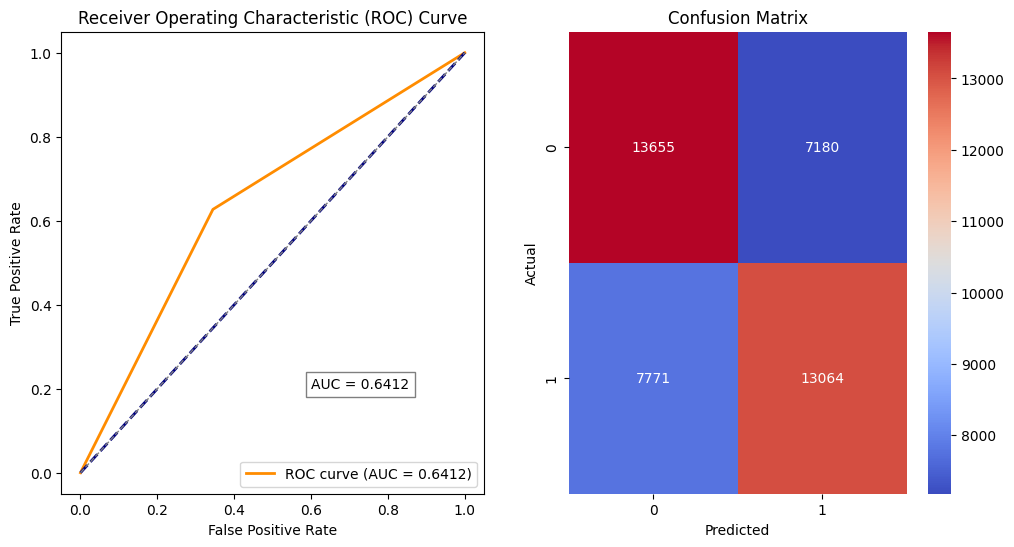

In [27]:
bow_logistic_model.fit(bow_train, df_train["is_spoiler"])
y_test = df_test["is_spoiler"]
y_pred = bow_logistic_model.predict(bow_test)

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

f1score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1score:.4f}")

bow_logistic_model_confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(bow_logistic_model_confusion_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc_bow_log = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_bow_log))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.4f}'.format(roc_auc_bow_log), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Confusion Matrix
[[13924  6911]
 [ 6886 13949]]
Classification Report
              precision    recall  f1-score   support

       False       0.67      0.67      0.67     20835
        True       0.67      0.67      0.67     20835

    accuracy                           0.67     41670
   macro avg       0.67      0.67      0.67     41670
weighted avg       0.67      0.67      0.67     41670

F1 Score: 0.6691


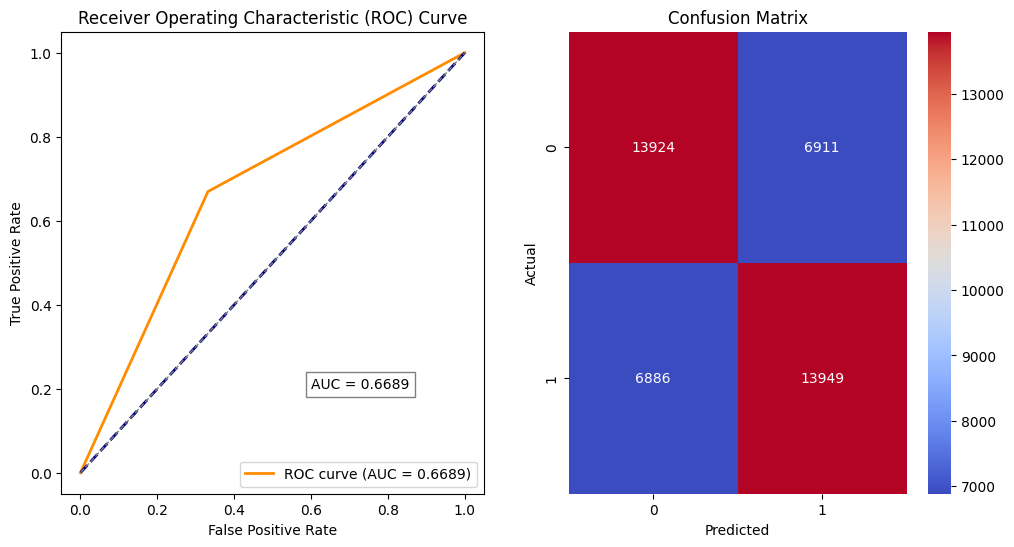

In [29]:
tfidf_logistic_model.fit(tfidf_train, df_train["is_spoiler"])
y_test = df_test["is_spoiler"]
y_pred = tfidf_logistic_model.predict(tfidf_test)

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

f1score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1score:.4f}")

tfidf_logistic_model_confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(tfidf_logistic_model_confusion_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc_tfidf_log = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_tfidf_log))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.4f}'.format(roc_auc_tfidf_log), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Confusion Matrix
[[ 9061 11774]
 [ 9207 11628]]
Classification Report
              precision    recall  f1-score   support

       False       0.50      0.43      0.46     20835
        True       0.50      0.56      0.53     20835

    accuracy                           0.50     41670
   macro avg       0.50      0.50      0.49     41670
weighted avg       0.50      0.50      0.49     41670

F1 Score: 0.5257


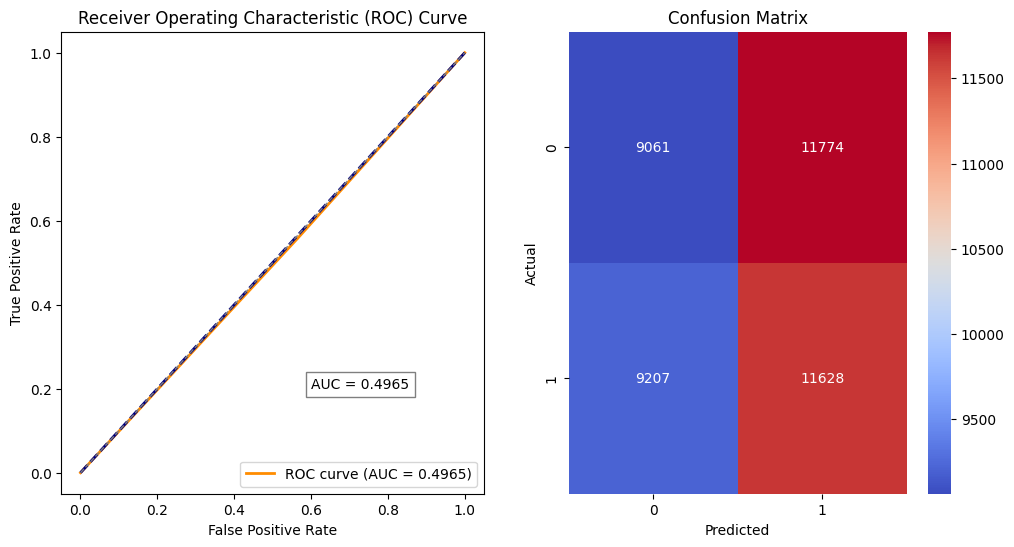

In [34]:
embedding_logistic_model.fit(embedding_train, df_train["is_spoiler"])
y_test = df_test["is_spoiler"]
y_pred = embedding_logistic_model.predict(embedding_test)

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

f1score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1score:.4f}")

embedding_logistic_model_confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(embedding_logistic_model_confusion_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc_embedding_log = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_embedding_log))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.4f}'.format(roc_auc_embedding_log), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

### 3.2 SVM

In [15]:
# svm_model
bow_svm_model = SVC(kernel = "sigmoid", max_iter = 10000)
tfidf_svm_model = SVC(kernel = "sigmoid", max_iter = 10000)

Confusion Matrix
[[12288  8547]
 [ 9723 11112]]
Classification Report
              precision    recall  f1-score   support

       False       0.56      0.59      0.57     20835
        True       0.57      0.53      0.55     20835

    accuracy                           0.56     41670
   macro avg       0.56      0.56      0.56     41670
weighted avg       0.56      0.56      0.56     41670

F1 Score: 0.5488


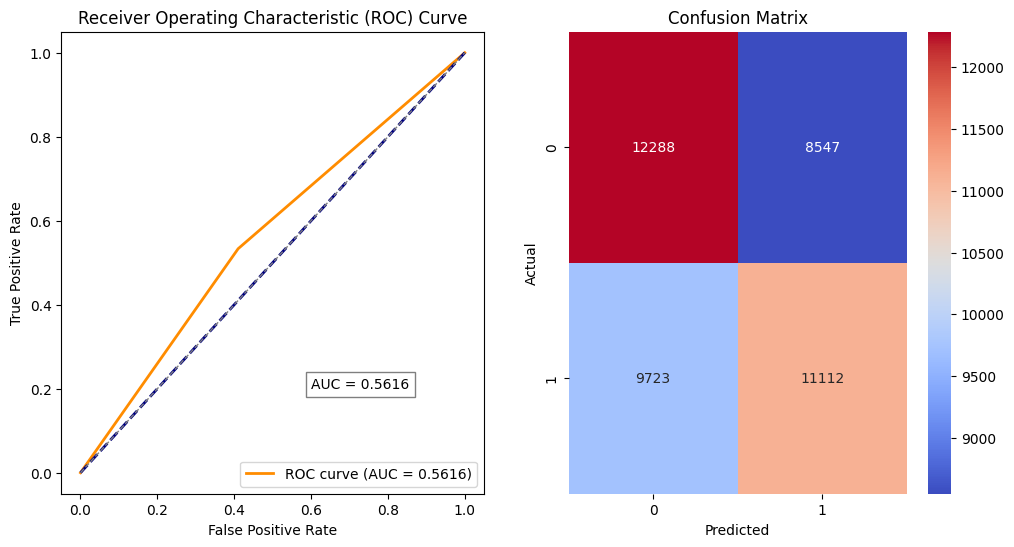

In [16]:
bow_svm_model.fit(bow_train, df_train["is_spoiler"])
y_test = df_test["is_spoiler"]
y_pred = bow_svm_model.predict(bow_test)

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

f1score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1score:.4f}")

bow_svm_model_confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(bow_svm_model_confusion_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc_bow_svm = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_bow_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.4f}'.format(roc_auc_bow_svm), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

In [17]:
tfidf_svm_model.fit(tfidf_train, df_train["is_spoiler"])
y_test = df_test["is_spoiler"]
y_pred = tfidf_svm_model.predict(tfidf_test)

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

f1score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1score:.4f}")

tfidf_svm_model_confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(tfidf_svm_model_confusion_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc_tfidf_svm = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_tfidf_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.4f}'.format(roc_auc_tfidf_svm), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

### 3.3 Artificial Neural Network

In [7]:
tfidf_coo_train = tfidf_train.tocoo()
indices = np.mat([tfidf_coo_train.row, tfidf_coo_train.col]).transpose()
tfidf_sparse_train = tf.sparse.reorder(tf.SparseTensor(indices, tfidf_coo_train.data, tfidf_coo_train.shape))

tfidf_coo_test = tfidf_test.tocoo()
indices = np.mat([tfidf_coo_test.row, tfidf_coo_test.col]).transpose()
tfidf_sparse_test = tf.sparse.reorder(tf.SparseTensor(indices, tfidf_coo_test.data, tfidf_coo_test.shape))

In [8]:
model = Sequential()
model.add(InputLayer(input_shape = (tfidf_train.shape[1],), sparse = True))
model.add(Dense(128, activation = "relu", kernel_regularizer = L2(1e-3)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [9]:
model.fit(tfidf_sparse_train, df_train["is_spoiler"].to_numpy(), validation_data = (tfidf_sparse_test, df_test["is_spoiler"].to_numpy()), epochs = 1)

8131/8131 [==============================] - 2501s 307ms/step - loss: 0.7620 - accuracy: 0.6681 - val_loss: 0.7854 - val_accuracy: 0.6466


1303/1303 [==============================] - 4s 3ms/step
Confusion Matrix
[[11455  9380]
 [ 5347 15488]]
Classification Report
              precision    recall  f1-score   support

       False       0.68      0.55      0.61     20835
        True       0.62      0.74      0.68     20835

    accuracy                           0.65     41670
   macro avg       0.65      0.65      0.64     41670
weighted avg       0.65      0.65      0.64     41670

F1 Score: 0.6778


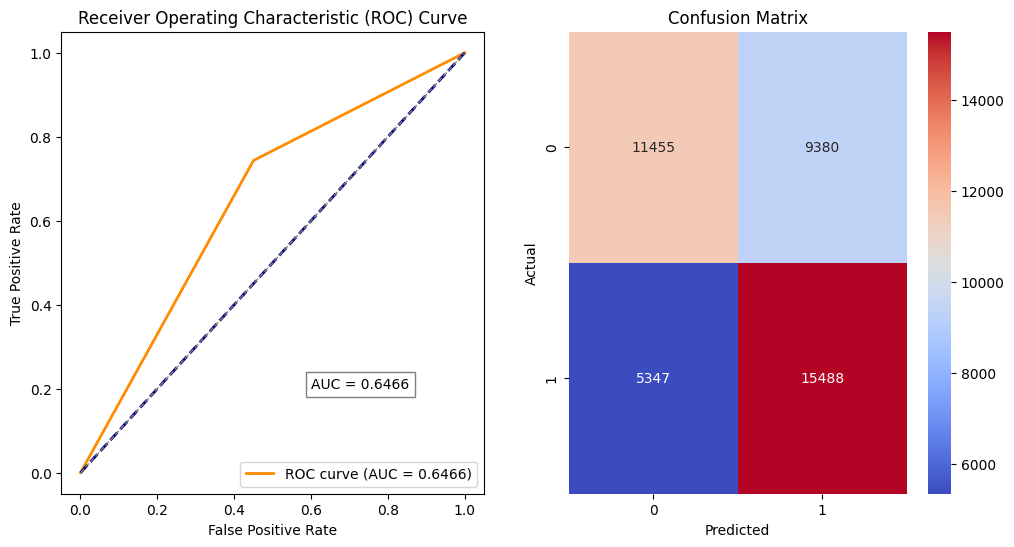

In [11]:
y_test = df_test["is_spoiler"]
y_pred_probs = model.predict(tfidf_sparse_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

f1score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1score:.4f}")

model_confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(model_confusion_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc_tfidf_model = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_tfidf_model))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.4f}'.format(roc_auc_tfidf_model), bbox=dict(facecolor='white', alpha=0.5))

plt.show()


### 3.4 Recurrent Neural Network

In [13]:
# RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim = 10000, output_dim = 128, input_length = 50))
rnn_model.add(SimpleRNN(units = 128, kernel_regularizer = L2(1e-3)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(128, activation = "relu"))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
rnn_model.fit(train_padded, df_train["is_spoiler"], validation_data = (test_padded, df_test["is_spoiler"]), epochs = 10)

Epoch 1/10
8131/8131 [==============================] - 169s 21ms/step - loss: 0.6806 - accuracy: 0.5775 - val_loss: 0.6930 - val_accuracy: 0.5673
Epoch 2/10
8131/8131 [==============================] - 165s 20ms/step - loss: 0.6601 - accuracy: 0.5986 - val_loss: 0.6953 - val_accuracy: 0.5828
Epoch 3/10
8131/8131 [==============================] - 168s 21ms/step - loss: 0.6588 - accuracy: 0.5935 - val_loss: 0.6992 - val_accuracy: 0.5355
Epoch 4/10
8131/8131 [==============================] - 164s 20ms/step - loss: 0.6630 - accuracy: 0.5836 - val_loss: 0.6884 - val_accuracy: 0.5349
Epoch 5/10
8131/8131 [==============================] - 172s 21ms/step - loss: 0.6647 - accuracy: 0.5753 - val_loss: 0.6970 - val_accuracy: 0.5604
Epoch 6/10
8131/8131 [==============================] - 170s 21ms/step - loss: 0.6660 - accuracy: 0.5800 - val_loss: 0.7168 - val_accuracy: 0.5465
Epoch 7/10
8131/8131 [==============================] - 172s 21ms/step - loss: 0.6612 - accuracy: 0.6079 - val_loss: 0

Confusion Matrix
[[ 7028 13807]
 [ 4437 16398]]
Classification Report
              precision    recall  f1-score   support

       False       0.61      0.34      0.44     20835
        True       0.54      0.79      0.64     20835

    accuracy                           0.56     41670
   macro avg       0.58      0.56      0.54     41670
weighted avg       0.58      0.56      0.54     41670

F1 Score: 0.6426


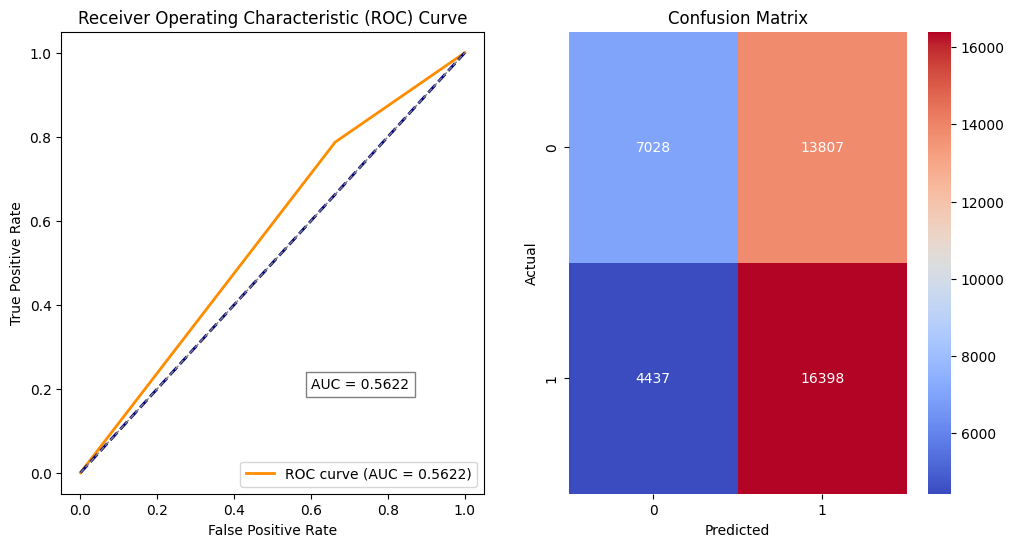

In [15]:
y_test = df_test["is_spoiler"]
y_pred = rnn_model.predict(test_padded, verbose = False) > 0.5

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

f1score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1score:.4f}")

rnn_model_confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(rnn_model_confusion_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc_rnn = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_rnn))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.4f}'.format(roc_auc_rnn), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

### 3.5 Long Short-Term Memory

In [16]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim = 10000, output_dim = 128, input_length = 50))
lstm_model.add(Bidirectional(LSTM(units = 128, kernel_regularizer = L2(1e-3))))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(128, activation = "relu"))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
lstm_model.fit(train_padded, df_train["is_spoiler"], validation_data = (test_padded, df_test["is_spoiler"]), epochs = 10)

Epoch 1/10
8131/8131 [==============================] - 590s 72ms/step - loss: 0.6331 - accuracy: 0.6282 - val_loss: 0.6827 - val_accuracy: 0.6066
Epoch 2/10
8131/8131 [==============================] - 552s 68ms/step - loss: 0.6113 - accuracy: 0.6549 - val_loss: 0.6686 - val_accuracy: 0.6018
Epoch 3/10
8131/8131 [==============================] - 540s 66ms/step - loss: 0.6009 - accuracy: 0.6677 - val_loss: 0.6778 - val_accuracy: 0.5998
Epoch 4/10
8131/8131 [==============================] - 538s 66ms/step - loss: 0.5910 - accuracy: 0.6789 - val_loss: 0.6932 - val_accuracy: 0.5973
Epoch 5/10
8131/8131 [==============================] - 576s 71ms/step - loss: 0.5808 - accuracy: 0.6895 - val_loss: 0.7025 - val_accuracy: 0.5967
Epoch 6/10
8131/8131 [==============================] - 558s 69ms/step - loss: 0.5698 - accuracy: 0.7000 - val_loss: 0.7013 - val_accuracy: 0.6002
Epoch 7/10
8131/8131 [==============================] - 552s 68ms/step - loss: 0.5592 - accuracy: 0.7095 - val_loss: 0

Confusion Matrix
[[12459  8376]
 [ 8651 12184]]
Classification Report
              precision    recall  f1-score   support

       False       0.59      0.60      0.59     20835
        True       0.59      0.58      0.59     20835

    accuracy                           0.59     41670
   macro avg       0.59      0.59      0.59     41670
weighted avg       0.59      0.59      0.59     41670

F1 Score: 0.5887


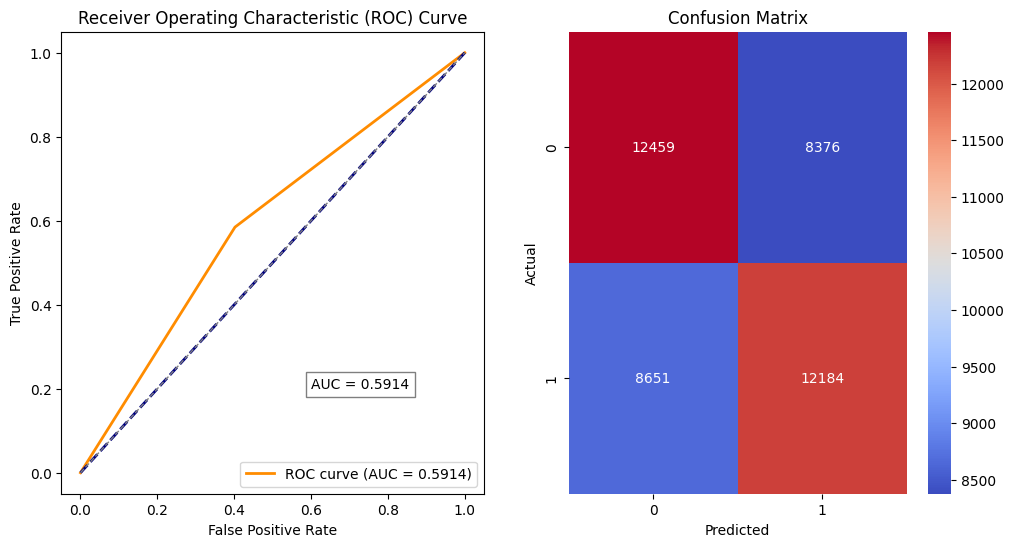

In [18]:
y_test = df_test["is_spoiler"]
y_pred = lstm_model.predict(test_padded, verbose = False) > 0.5

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

f1score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1score:.4f}")

lstm_model_confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(lstm_model_confusion_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate the AUC score
roc_auc_lstm = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc_lstm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.4f}'.format(roc_auc_lstm), bbox=dict(facecolor='white', alpha=0.5))

plt.show()